<a href="https://colab.research.google.com/github/cebisiles/unsupervised-predict-streamlit-template/blob/master/Movie_review_Predict_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import our regular old heroes 
import numpy as np
import pandas as pd
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficientcy. 
import matplotlib.pyplot as plt
import seaborn as sns

# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

In [ ]:
movie_ratings = pd.read_csv('movies.csv')
imdb_data = pd.read_csv('imdb_data.csv')
ratings = pd.read_csv('ratings.csv')
train = pd.read_csv('train.csv')

In [ ]:
movie_ratings = movie_ratings.merge(train, on='movieId')

In [ ]:
movie_ratings =movie_ratings.drop(['genres','timestamp'],axis=1).dropna(axis=0)

In [ ]:
movie_ratings.head()

,movieId,title,userId,rating
0,1,Toy Story (1995),158849,5.0
1,1,Toy Story (1995),97203,5.0
2,1,Toy Story (1995),161871,3.0
3,1,Toy Story (1995),45117,4.0
4,1,Toy Story (1995),27431,5.0


In [ ]:
print (f'Number of ratings in dataset: {movie_ratings.shape[0]}')

Number of ratings in dataset: 10000038


In [ ]:
movie_ratings = movie_ratings.sample(10000)

In [ ]:
movie_ratings.shape

(10000, 4)

In [ ]:
util_matrix = movie_ratings.pivot_table(index=['userId'],
                                       columns=['title'],
                                       values='rating')
util_matrix.shape

(9013, 3685)

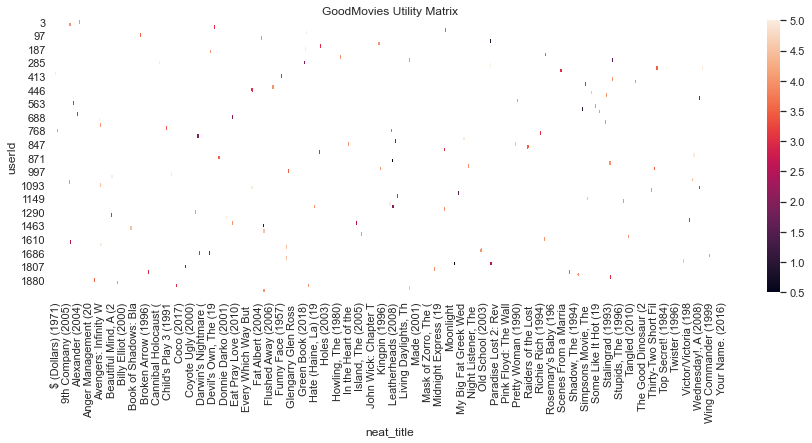

In [ ]:
# Create a neat version of the utility matrix to assist with plotting movie titles 
movie_ratings['neat_title'] = movie_ratings['title'].apply(lambda x: x[:20])
util_matrix_neat = movie_ratings.pivot_table(index=['userId'],
                                            columns=['neat_title'],
                                            values='rating')

fig, ax = plt.subplots(figsize=(15,5))
# We select only the first 100 users for ease of computation and visualisation. 
# You can play around with this value to see more of the utility matrix. 
_ = sns.heatmap(util_matrix_neat[:100], annot=False, ax=ax).set_title('GoodMovies Utility Matrix')

In [ ]:
# Normalize each row (a given user's ratings) of the utility matrix
util_matrix_norm = util_matrix.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)
# Fill Nan values with 0's, transpose matrix, and drop users with no ratings
util_matrix_norm.fillna(0, inplace=True)
util_matrix_norm = util_matrix_norm.T
util_matrix_norm = util_matrix_norm.loc[:, (util_matrix_norm != 0).any(axis=0)]
# Save the utility matrix in scipy's sparse matrix format
util_matrix_sparse = sp.sparse.csr_matrix(util_matrix_norm.values)

In [ ]:
# Compute the similarity matrix using the cosine similarity metric
user_similarity = cosine_similarity(util_matrix_sparse.T)
# Save the matrix as a dataframe to allow for easier indexing  
user_sim_df = pd.DataFrame(user_similarity,
                           index = util_matrix_norm.columns,
                           columns = util_matrix_norm.columns)

# Review a small portion of the constructed similartiy matrix  
user_sim_df[:5]

userId,279,285,388,768,847,983,1115,1242,1401,1686,...,160858,160948,161478,161560,161799,162047,162145,162358,162516,162521
userId,,,,,,,,,,,,,,,,,,,,,
279,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
285,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
388,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
768,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
847,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def collab_generate_top_N_recommendations(user, N=10, k=20):
    # Cold-start problem - no ratings given by the reference user. 
    # With no further user data, we solve this by simply recommending
    # the top-N most popular books in the item catalog. 
    if user not in user_sim_df.columns:
        return movie_ratings.groupby('title').mean().sort_values(by='rating',
                                        ascending=False).index[:N].to_list()

    # Gather the k users which are most similar to the reference user 
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:k+1]
    favorite_user_items = [] # <-- List of highest rated items gathered from the k users  
    most_common_favorites = {} # <-- Dictionary of highest rated items in common for the k users

    for i in sim_users:
        # Maximum rating given by the current user to an item 
        max_score = util_matrix_norm.loc[:, i].max()
        # Save the names of items maximally rated by the current user   
        favorite_user_items.append(util_matrix_norm[util_matrix_norm.loc[:, i]==max_score].index.tolist())

    # Loop over each user's favorite items and tally which ones are 
    # most popular overall.
    for item_collection in range(len(favorite_user_items)):
        for item in favorite_user_items[item_collection]:
            if item in most_common_favorites:
                most_common_favorites[item] += 1
            else:
                most_common_favorites[item] = 1
    # Sort the overall most popular items and return the top-N instances
    sorted_list = sorted(most_common_favorites.items(), key=operator.itemgetter(1), reverse=True)[:N]
    top_N = [x[0] for x in sorted_list]
    return top_N

In [ ]:
# Our recommended list for user 285
collab_generate_top_N_recommendations(285)

['Philadelphia (1993)',
 'Eat Drink Man Woman (Yin shi nan nu) (1994)',
 'Demolition Man (1993)',
 'Speed (1994)',
 'Eye, The (Gin gwai) (Jian gui) (2002)',
 'Jerry and Tom (1998)',
 'Usual Suspects, The (1995)',
 'Cat on a Hot Tin Roof (1958)',
 'Clockwork Orange, A (1971)',
 'Chloe (2009)']

In [ ]:
# User 285's historical ratings
movie_ratings[movie_ratings['userId'] == 285][:][['title','rating']].sort_values(by='rating', ascending=False)[:10]

,title,rating
3066925,Carrie (1976),5.0
3866498,Gremlins (1984),2.0


In [ ]:
def collab_generate_rating_estimate(movie_title, user, k=20, threshold=0.0):
    # Gather the k users which are most similar to the reference user 
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:k+1]
    # Store the corresponding user's similarity values 
    user_values = user_sim_df.sort_values(by=user, ascending=False).loc[:,user].tolist()[1:k+1]
    rating_list = [] # <-- List of k user's ratings for the reference item
    weight_list = [] # <-- List of k user's similarities to the reference user

    # Create a weighted sum for each of the k users who have rated the 
    # reference item (book).
    for sim_idx, userId in enumerate(sim_users):
        # User's rating of the item
        rating = util_matrix.loc[userId, movie_title]
        # User's similarity to the reference user 
        similarity = user_values[sim_idx]
        # Skip the user if they have not rated the item, or are too dissimilar to 
        # the reference user
        if (np.isnan(rating)) or (similarity < threshold):
            continue
        elif not np.isnan(rating):
            rating_list.append(rating*similarity)
            weight_list.append(similarity)
    try:
        # Return the weighted sum as the predicted rating for the reference item
        predicted_rating = sum(rating_list)/sum(weight_list)
    except ZeroDivisionError:
        # If no ratings for the reference item can be collected, return the average 
        # rating given by all users for the item.  
        predicted_rating = np.mean(util_matrix[movie_title])
    return predicted_rating

In [ ]:
title = "Carrie (1976)"
actual_rating = movie_ratings[(movie_ratings['userId'] == 285) & (movie_ratings['title'] == title)]['rating'].values[0]
pred_rating = collab_generate_rating_estimate(movie_title = title, user = 285)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Title - Carrie (1976)
---
Actual rating: 		 5.0
Predicted rating: 	 4.083333333333333


In [ ]:
title = "Philadelphia (1993)"
pred_rating = collab_generate_rating_estimate(movie_title = title, user = 285)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t ?")
print (f"Predicted rating: \t {pred_rating}")

Title - Philadelphia (1993)
---
Actual rating: 		 ?
Predicted rating: 	 5.0


In [ ]:
title = "Eat Drink Man Woman (Yin shi nan nu) (1994)"
pred_rating = collab_generate_rating_estimate(movie_title = title, user = 285)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t ?")
print (f"Predicted rating: \t {pred_rating}")

Title - Eat Drink Man Woman (Yin shi nan nu) (1994)
---
Actual rating: 		 ?
Predicted rating: 	 3.5


In [ ]:
my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': predicted_prices})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)